## Preprocessing and Data Collection

In [ ]:
import cv2
import os


video_dir = 'recordings'  
output_dir = 'data/temporal'
os.makedirs(output_dir, exist_ok=True)
frame_interval = 60 
video_extensions = ('.mp4', '.mov', '.avi', '.mkv')

# Process each video in the directory
for video_filename in os.listdir(video_dir):
    if not video_filename.lower().endswith(video_extensions):
        continue

    video_path = os.path.join(video_dir, video_filename)
    video_name = os.path.splitext(video_filename)[0]

    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    saved_count = 0

    print(f"Processing {video_filename}...")

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            frame_filename = os.path.join(
                output_dir, f"{video_name}_frame_{saved_count:04d}.jpg"
            )
            cv2.imwrite(frame_filename, frame)
            saved_count += 1

        frame_count += 1

    cap.release()
    print(f"Saved {saved_count} frames from '{video_filename}'")

print("Done extracting all frames to one directory.")

In [8]:
from PIL import Image
import os

input_dir = "data/single"
output_dir = "processed_images/single"
target_size = (1024, 768)

os.makedirs(output_dir, exist_ok=True)

images = sorted([f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png'))])

for idx, filename in enumerate(images, start=1):
    with Image.open(os.path.join(input_dir, filename)) as img:
        img_resized = img.resize(target_size)
        output_name = f"img{idx:03}.jpg"
        img_resized.save(os.path.join(output_dir, output_name))

print(f"Processed {len(images)} images.")



Processed 47 images.


In [42]:
from PIL import Image
import os

input_dir = "colmap_workspace/images"
# input_dir = "processed_images/ics"  

images = sorted([f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.png'))])

dims = {}

for filename in images:
    with Image.open(os.path.join(input_dir, filename)) as img:
        width, height = img.size
        dims[filename] = (width, height)

for filename, (w, h) in dims.items():
    print(f"{filename}: {w}x{h}")

img001.jpg: 1024x768
img002.jpg: 1024x768
img003.jpg: 1024x768
img004.jpg: 1024x768
img005.jpg: 1024x768
img006.jpg: 1024x768
img007.jpg: 1024x768
img008.jpg: 1024x768
img009.jpg: 1024x768
img010.jpg: 1024x768
img011.jpg: 1024x768
img012.jpg: 1024x768
img013.jpg: 1024x768
img014.jpg: 1024x768
img015.jpg: 1024x768
img016.jpg: 1024x768
img017.jpg: 1024x768
img018.jpg: 1024x768
img019.jpg: 1024x768
img020.jpg: 1024x768


In [ ]:
import os
import shutil
import subprocess

PROJECT_ROOT = os.getcwd()  
WORKSPACE = os.path.join(PROJECT_ROOT, "colmap_workspace4")
IMAGES_SRC = os.path.join(PROJECT_ROOT, "processed_images/ics")
IMAGES_DST = os.path.join(WORKSPACE, "images")
DATABASE_PATH = os.path.join(WORKSPACE, "database.db")
SPARSE_PATH = os.path.join(WORKSPACE, "sparse")

os.makedirs(IMAGES_DST, exist_ok=True)
os.makedirs(SPARSE_PATH, exist_ok=True)

for filename in os.listdir(IMAGES_SRC):
    if filename.lower().endswith((".jpg", ".png", ".jpeg")):
        shutil.copy(os.path.join(IMAGES_SRC, filename), IMAGES_DST)

def run_colmap_command(args, description):
    print(f"\n[Running] {description}...")
    result = subprocess.run(args, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    if result.returncode != 0:
        print(f"[Error] {description} failed:\n{result.stderr.decode()}")
        exit(1)
    print(f"[Success] {description}")


run_colmap_command([
    "colmap", "feature_extractor",
    "--database_path", DATABASE_PATH,
    "--image_path", IMAGES_DST
], "Feature Extraction")


run_colmap_command([
    "colmap", "exhaustive_matcher",
    "--database_path", DATABASE_PATH
], "Exhaustive Matching")


MAPPER_OUTPUT = os.path.join(SPARSE_PATH, "0")
os.makedirs(MAPPER_OUTPUT, exist_ok=True)
run_colmap_command([
    "colmap", "mapper",
    "--database_path", DATABASE_PATH,
    "--image_path", IMAGES_DST,
    "--output_path", SPARSE_PATH
], "Sparse Reconstruction")

print("\nCOLMAP sparse SfM pipeline completed successfully.")
print(f"Output saved to: {MAPPER_OUTPUT}")

In [ ]:
# 4. Convert Binary to PLY file
run_colmap_command([
    "colmap", "model_converter",
    "--input_path", MAPPER_OUTPUT,
    "--output_path", MAPPER_OUTPUT,
    "--output_type", "PLY"
], "Model Conversion to PLY")


## Dense Reconstruction Pipeline

In [ ]:
# --- Configuration ---
project_root = "colmap_workspace"
images_dir = os.path.join(project_root, "images")
sparse_model_dir = os.path.join(project_root, "sparse", "0")
dense_dir = os.path.join(project_root, "dense")
fused_ply = os.path.join(dense_dir, "fused.ply")
poisson_mesh = os.path.join(dense_dir, "meshed-poisson.ply")
delaunay_mesh = os.path.join(dense_dir, "meshed-delaunay.ply")

os.makedirs(dense_dir, exist_ok=True)

# --- Step 1: Undistort Images ---
print("\n[1/4] Undistorting images...")
subprocess.run([
    "colmap", "image_undistorter",
    "--image_path", images_dir,
    "--input_path", sparse_model_dir,
    "--output_path", dense_dir,
    "--output_type", "COLMAP"
], check=True)



In [ ]:
print("\n[2/4] Running PatchMatch Stereo...")
subprocess.run([
    "colmap", "patch_match_stereo",
    "--workspace_path", dense_dir,
    "--workspace_format", "COLMAP",
    "--PatchMatchStereo.geom_consistency", "true"
], check=True)

In [ ]:
print("\n[3/4] Fusing depth maps into dense point cloud...")
subprocess.run([
    "colmap", "stereo_fusion",
    "--workspace_path", dense_dir,
    "--workspace_format", "COLMAP",
    "--input_type", "geometric",
    "--output_path", fused_ply
], check=True)

In [ ]:
print("\n[4/4] Running Poisson mesher...")
subprocess.run([
    "colmap", "poisson_mesher",
    "--input_path", fused_ply,
    "--output_path", poisson_mesh
], check=True)
print("\nDense reconstruction complete.")

## Create Depth Maps for ICS Building

In [1]:
!cd MiDaS
!python run.py --model_type dpt_hybrid_384 --input_path ../processed_images/single/img008.jpg --output_path ../depth_maps/single
!cd ..

python: can't open file '/Users/sumitraut/Dev/SateliteImgSfm/run.py': [Errno 2] No such file or directory


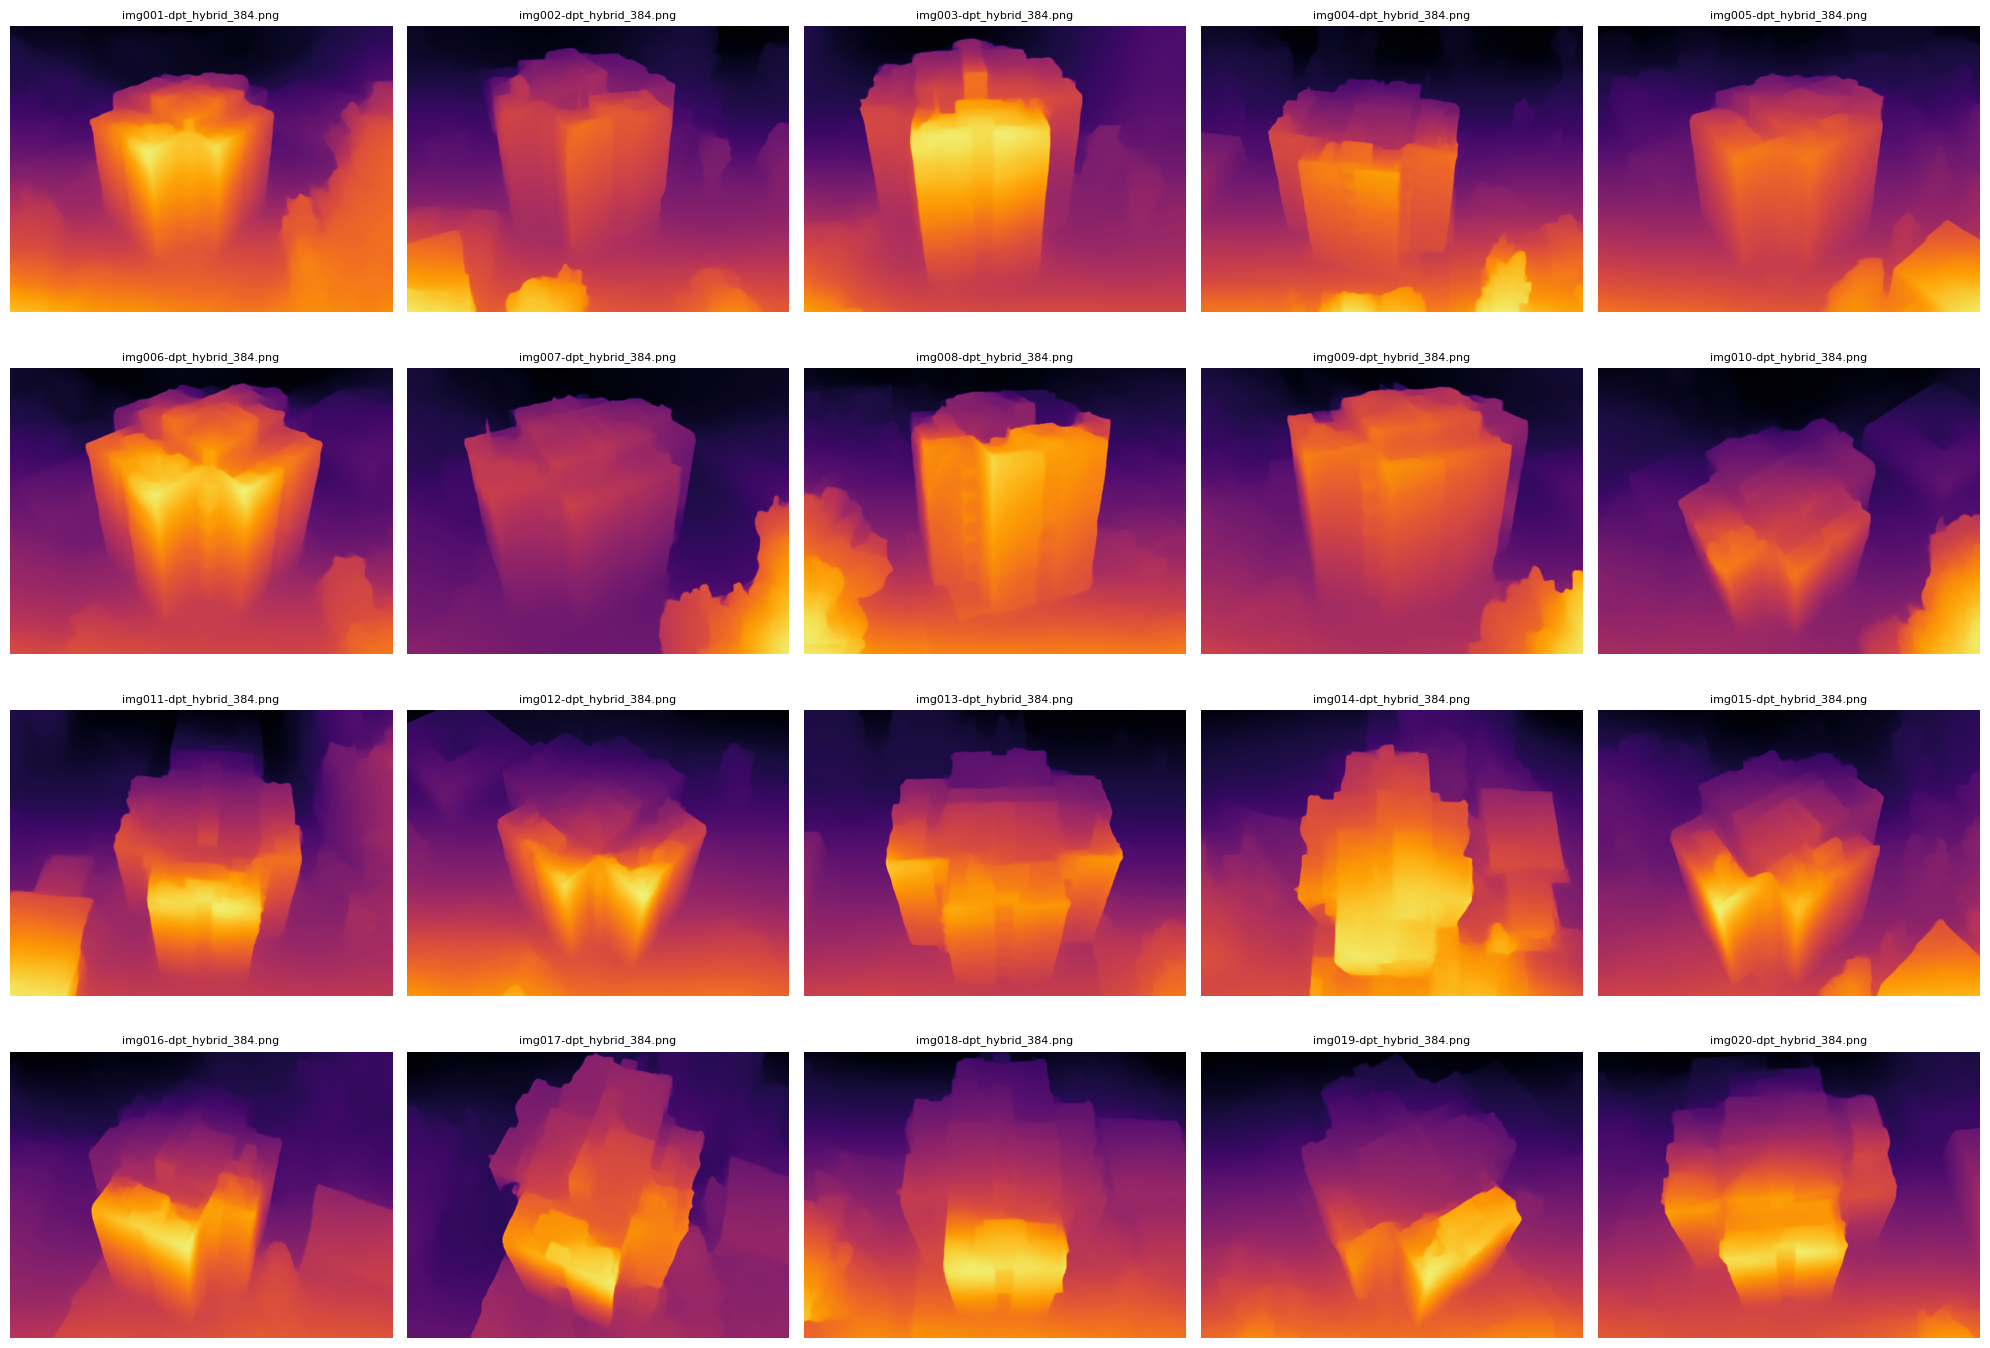

In [48]:
import os
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === CONFIGURATION ===
depth_dir = Path("depth_maps")  # Change this to your directory
colormap = cv2.COLORMAP_INFERNO  # Or JET, MAGMA, etc.
max_images = 30  # Max number of images to show in grid

# === Load all .png depth maps ===
depth_paths = sorted(depth_dir.glob("*.png"))[:max_images]
depth_images = []

for depth_path in depth_paths:
    depth = cv2.imread(str(depth_path), cv2.IMREAD_UNCHANGED)

    if depth is None:
        print(f"Failed to load {depth_path}")
        continue

    # Normalize and apply colormap
    depth_vis = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX)
    depth_vis = depth_vis.astype('uint8')
    depth_color = cv2.applyColorMap(depth_vis, colormap)
    depth_rgb = cv2.cvtColor(depth_color, cv2.COLOR_BGR2RGB)
    depth_images.append((depth_rgb, depth_path.name))

# === Compute grid size ===
n_images = len(depth_images)
cols = 5  # You can change this
rows = math.ceil(n_images / cols)

# === Plot grid ===
fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 3.5 * rows))
axes = axes.flatten()

for i in range(rows * cols):
    ax = axes[i]
    if i < n_images:
        img, title = depth_images[i]
        ax.imshow(img)
        ax.set_title(title, fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()

## Loading Saved Camera Parameters

In [50]:
!git clone https://github.com/colmap/colmap
!cd colmap/scripts/python

Cloning into 'colmap'...
remote: Enumerating objects: 28234, done.
remote: Counting objects: 100% (458/458), done.
remote: Compressing objects: 100% (235/235), done.
remote: Total 28234 (delta 345), reused 241 (delta 223), pack-reused 27776 (from 3)
Receiving objects: 100% (28234/28234), 71.13 MiB | 5.81 MiB/s, done.
Resolving deltas: 100% (21704/21704), done.


In [1]:
from read_write_model import read_images_binary, read_cameras_binary, qvec2rotmat
import numpy as np

images = read_images_binary("colmap_workspace/sparse/0/images.bin")
cameras = read_cameras_binary("colmap_workspace/sparse/0/cameras.bin")

camera_dict = {}
for image_id, image in images.items():
    cam = cameras[image.camera_id]
    K = np.array([[cam.params[0], 0, cam.params[2]],
                  [0, cam.params[1], cam.params[3]],
                  [0, 0, 1]])
    
    # world to cam -> inverse)
    R = qvec2rotmat(image.qvec)
    t = image.tvec.reshape(3, 1)
    ext = np.eye(4)
    ext[:3, :3] = R
    ext[:3, 3] = t[:, 0]
    cam2world = np.linalg.inv(ext)  

    camera_dict[image.name] = (K, cam2world)

In [2]:
camera_dict['img001.jpg']

(array([[ 7.01428543e+02,  0.00000000e+00,  3.84000000e+02],
        [ 0.00000000e+00,  5.12000000e+02, -9.53105221e-02],
        [ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00]]),
 array([[-0.86513303, -0.1930652 ,  0.46289379, -2.33711895],
        [ 0.44543778,  0.12839305,  0.88605892, -2.33849669],
        [-0.23049949,  0.97274922, -0.02507854,  3.7712729 ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

## Load and Convert .pfm Depth Map

In [3]:
def load_pfm(path):
    with open(path, 'rb') as f:
        header = f.readline().decode().rstrip()
        color = header == 'PF'
        dims = list(map(int, f.readline().decode().split()))
        scale = float(f.readline().decode())
        endian = '<' if scale < 0 else '>'
        data = np.fromfile(f, endian + 'f')
        shape = (dims[1], dims[0], 3) if color else (dims[1], dims[0])
        return np.flipud(np.reshape(data, shape))

def backproject(depth, K, cam2world):
    H, W = depth.shape
    i, j = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
    z = depth
    x = (i - K[0, 2]) * z / K[0, 0]
    y = (j - K[1, 2]) * z / K[1, 1]
    pts_cam = np.stack((x, y, z), axis=-1).reshape(-1, 3)

    # Transform to world coordinates
    R = cam2world[:3, :3]
    t = cam2world[:3, 3]
    pts_world = pts_cam @ R.T + t
    return pts_world

## Trying to fuse reprojected points from depthmap in original point cloud

In [4]:
import open3d as o3d
from pathlib import Path

all_points = []

depth_dir = Path("depth_maps")
for image_name, (K, cam2world) in camera_dict.items():
    base = image_name.rsplit('.', 1)[0]
    pfm_path = depth_dir / f"{base}-dpt_hybrid_384.pfm"
    
    if pfm_path.exists():
        depth = load_pfm(str(pfm_path))
        points = backproject(depth, K, cam2world)
        
        valid = np.logical_and(depth.flatten() > 0, depth.flatten() < 1000)
        points = points[valid]
        
        all_points.append(points)
        
all_points = np.vstack(all_points)


In [5]:
all_points

array([[ 357.74886233,  244.60425335,   42.71853337],
       [ 354.81625386,  243.15862872,   42.32679232],
       [ 350.29098204,  240.60791805,   41.76448189],
       ...,
       [-420.48033424, 1220.02026688,  767.42648294],
       [-420.90986915, 1221.14861955,  766.68866172],
       [-421.33241736, 1222.25658411,  765.9378848 ]])

In [6]:
pc = o3d.geometry.PointCloud()
pc.points = o3d.utility.Vector3dVector(all_points)
pc.estimate_normals()
o3d.io.write_point_cloud("fused_point_cloud.ply", pc)


True

# Evaluation

## Sparse Reconstruction Evaluation

In [ ]:
import numpy as np
from colmap_utils import read_model

cameras, images, points3D = read_model("/content/drive/MyDrive/colmap_workspace_temporal/sparse/0", ext=".bin")
print("Number of registered images:", len(images))
print("Number of points:", len(points3D))

errors = [p.error for p in points3D.values()]
print("Temporal satelite images details:")
print("Mean reprojection error:", np.mean(errors))

In [3]:
import open3d as o3d
import numpy as np

source = o3d.io.read_point_cloud("final_results/FINAL.ply")
target = o3d.io.read_point_cloud("final_results/single1.ply")


distances = source.compute_point_cloud_distance(target)
print("Mean distance:", np.mean(distances))
print("Std deviation:", np.std(distances))


Mean distance: 2.6892050553260156
Std deviation: 1.7310975392629087


In [ ]:

from colmap_utils import read_model

cameras, images, points3D = read_model("sparse_model_path", ext=".bin")
print("Number of registered images:", len(images))
print("Number of points:", len(points3D))

# Access reprojection error
errors = [p.error for p in points3D.values()]
print("Mean reprojection error:", np.mean(errors))


In [12]:
from tabulate import tabulate
import pandas as pd

data = {
    "Dataset Type": [
        "3D-enabled Satellite Images",
        "Temporal Satellite Images (2005–2025)",
        "Current Satellite Images (2D only)"
    ],
    "Registered Images": [132, 279, 47],
    "3D Points": [112177, 309103, 88436],
    "Mean Reprojection Error": [0.7343, 1.0924, 1.1614]
}

df = pd.DataFrame(data)
print(tabulate(df, headers='keys', tablefmt='grid'))

+----+---------------------------------------+---------------------+-------------+---------------------------+
|    | Dataset Type                          |   Registered Images |   3D Points |   Mean Reprojection Error |
+====+=======================================+=====================+=============+===========================+
|  0 | 3D-enabled Satellite Images           |                 132 |      112177 |                    0.7343 |
+----+---------------------------------------+---------------------+-------------+---------------------------+
|  1 | Temporal Satellite Images (2005–2025) |                 279 |      309103 |                    1.0924 |
+----+---------------------------------------+---------------------+-------------+---------------------------+
|  2 | Current Satellite Images (2D only)    |                  47 |       88436 |                    1.1614 |
+----+---------------------------------------+---------------------+-------------+---------------------------+


## Dense Reconstruction Evaluation

In [16]:
import open3d as o3d
pc3d = o3d.io.read_point_cloud("final_results/FINAL.ply")
print("Dense point countfor 3d enabled images:", len(pc3d.points))
pcs = o3d.io.read_point_cloud("final_results/single1.ply")
print("Dense point count for single year images:", len(pcs.points))
pct = o3d.io.read_point_cloud("final_results/temporal_fused.ply")
print("Dense point count for temporal images:", len(pct.points))

Dense point countfor 3d enabled images: 166123
Dense point count for single year images: 572388
Dense point count for temporal images: 3407540


In [14]:
import open3d as o3d
import os
import pandas as pd

pipelines = {
    "Current Year Satellite (30 images)": "final_results/single1.ply",
    "Temporal Satellite (2005–2025, 300 images)": "final_results/temporal_fused.ply",
    "3D-enabled Satellite (115 images)": "final_results/FINAL.ply"
}

results = []

for name, ply_path in pipelines.items():
    if not os.path.exists(ply_path):
        print(f"[WARNING] {name}: fused.ply not found")
        continue

    print(f"[INFO] Processing: {name}")
    pcd = o3d.io.read_point_cloud(ply_path)
    
    num_points = len(pcd.points)
    bounds = pcd.get_axis_aligned_bounding_box()
    volume = bounds.volume()
    min_bound = bounds.get_min_bound()
    max_bound = bounds.get_max_bound()

    results.append({
        "Pipeline": name,
        "Points": num_points,
        "Volume (m³)": round(volume, 2),
        "BBox Min": min_bound,
        "BBox Max": max_bound
    })

df = pd.DataFrame(results)
print("Point Cloud Evaluation Summary:\n")
print(df.to_markdown(index=False))

[INFO] Processing: Current Year Satellite (30 images)
[INFO] Processing: Temporal Satellite (2005–2025, 300 images)
[INFO] Processing: 3D-enabled Satellite (115 images)
Point Cloud Evaluation Summary:

| Pipeline                                   |   Points |   Volume (m³) | BBox Min                              | BBox Max                              |
|:-------------------------------------------|---------:|--------------:|:--------------------------------------|:--------------------------------------|
| Current Year Satellite (30 images)         |   572388 |        973.61 | [-7.50090694 -1.58401287  4.94808626] | [ 3.84985375  7.55743885 14.33110809] |
| Temporal Satellite (2005–2025, 300 images) |  3407540 |      18512.8  | [-6.05751705 -2.93342924  0.33342603] | [ 6.037323   12.68048382 98.3634491 ] |
| 3D-enabled Satellite (115 images)          |   166123 |       1497.63 | [-5.94585037 -2.38683796 -0.87460494] | [ 8.49346352 10.00275803  7.49685955] |
